In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import commons as cmns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
# from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# from IPython.display import Audio
# sound_file = 'beep.wav'

In [2]:
data=pd.read_csv('../Data/ethereum_Data.csv',sep=',')

In [3]:
data.interpolate(axis=0,inplace=True)

In [4]:
interval=(data['Date'] >= '2016/01/01') & (data['Date'] <= '2019/12/31')

interval1 = (data['Date'] >= '2013/04/01') & (data['Date'] <= '2016/04/01')
interval2=(data['Date'] >= '2013/04/01') & (data['Date'] <= '2017/04/01')
interval3=(data['Date'] >= '2013/04/01') & (data['Date'] <= '2019/12/31')

In [5]:
one=data['priceUSD'].shift(-1,fill_value=1)
seven=data['priceUSD'].shift(-7,fill_value=1)
fourteen=data['priceUSD'].shift(-14,fill_value=1)
thirty=data['priceUSD'].shift(-30,fill_value=1)
sixty=data['priceUSD'].shift(-60,fill_value=1)
ninety=data['priceUSD'].shift(-90,fill_value=1)

In [6]:
df=data.loc[interval]

In [7]:
df['priceUSD']=thirty.loc[interval].copy() # shift 30 days to predict the price after 30 days

/tmp/ipykernel_103894/2886425534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['priceUSD']=thirty.loc[interval].copy() # shift 30 days to predict the price after 30 days


In [8]:
df.shape

(1461, 692)

In [9]:
df.reset_index(inplace=True)
df

,index,Unnamed: 0,Date,priceUSD,transactions,size,sentbyaddress,difficulty,hashrate,mining_profitability,...,price3rsiUSD,price7rsiUSD,price14rsiUSD,price30rsiUSD,price90rsiUSD,price3rocUSD,price7rocUSD,price14rocUSD,price30rocUSD,price90rocUSD
0,0,0,2016/01/01,2.387,8233,884.598,1536,8.547423e+12,5.260800e+11,4.760000e-08,...,92.690,73.145,60.943,53.834,49.657,12.383,9.778,2.890,13.496,38.596
1,1,1,2016/01/02,2.222,9164,953.560,1619,8.147466e+12,5.280537e+11,5.010000e-08,...,93.582,74.484,61.823,54.184,49.701,7.438,11.823,5.921,18.831,43.084
2,2,2,2016/01/03,2.237,9258,955.046,1618,8.312405e+12,5.448406e+11,4.980000e-08,...,95.478,77.482,63.831,54.993,49.805,2.734,15.467,6.441,19.724,48.484
3,3,3,2016/01/04,2.428,9474,981.314,1629,8.334160e+12,5.412908e+11,4.930000e-08,...,76.132,71.835,61.822,54.423,49.745,1.316,13.550,7.329,14.950,56.364
4,4,4,2016/01/05,2.535,16430,1396.000,1631,8.305862e+12,5.488611e+11,4.960000e-08,...,78.462,72.663,62.277,54.596,49.767,0.955,14.212,7.921,13.915,54.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,1456,1456,2019/12/27,163.699,579990,24644.000,159719,2.492178e+15,1.512355e+14,9.010000e-09,...,26.455,27.759,27.303,32.038,42.094,-2.085,-1.700,-12.901,-15.432,-27.262
1457,1457,1457,2019/12/28,168.986,516349,21575.000,145008,2.529318e+15,1.544558e+14,8.970000e-09,...,57.104,38.420,32.136,33.849,42.448,1.447,-0.001,-10.880,-16.146,-24.507
1458,1458,1458,2019/12/29,172.297,480131,21031.000,134423,2.559613e+15,1.548763e+14,9.100000e-09,...,79.503,52.666,39.686,36.890,43.064,3.826,1.372,-7.826,-14.348,-23.747
1459,1459,1459,2019/12/30,176.670,584426,24593.000,173853,2.548326e+15,1.546528e+14,9.340000e-09,...,86.262,59.528,43.907,38.721,43.448,6.042,1.265,-4.800,-12.681,-25.296


In [10]:
df = df.iloc[:,2:]
df

,Date,priceUSD,transactions,size,sentbyaddress,difficulty,hashrate,mining_profitability,sentinusdUSD,transactionfeesUSD,...,price3rsiUSD,price7rsiUSD,price14rsiUSD,price30rsiUSD,price90rsiUSD,price3rocUSD,price7rocUSD,price14rocUSD,price30rocUSD,price90rocUSD
0,2016/01/01,2.387,8233,884.598,1536,8.547423e+12,5.260800e+11,4.760000e-08,330634,0.00182,...,92.690,73.145,60.943,53.834,49.657,12.383,9.778,2.890,13.496,38.596
1,2016/01/02,2.222,9164,953.560,1619,8.147466e+12,5.280537e+11,5.010000e-08,250428,0.00204,...,93.582,74.484,61.823,54.184,49.701,7.438,11.823,5.921,18.831,43.084
2,2016/01/03,2.237,9258,955.046,1618,8.312405e+12,5.448406e+11,4.980000e-08,363640,0.00206,...,95.478,77.482,63.831,54.993,49.805,2.734,15.467,6.441,19.724,48.484
3,2016/01/04,2.428,9474,981.314,1629,8.334160e+12,5.412908e+11,4.930000e-08,149848,0.00219,...,76.132,71.835,61.822,54.423,49.745,1.316,13.550,7.329,14.950,56.364
4,2016/01/05,2.535,16430,1396.000,1631,8.305862e+12,5.488611e+11,4.960000e-08,1010627,0.00358,...,78.462,72.663,62.277,54.596,49.767,0.955,14.212,7.921,13.915,54.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2019/12/27,163.699,579990,24644.000,159719,2.492178e+15,1.512355e+14,9.010000e-09,159047767,0.07740,...,26.455,27.759,27.303,32.038,42.094,-2.085,-1.700,-12.901,-15.432,-27.262
1457,2019/12/28,168.986,516349,21575.000,145008,2.529318e+15,1.544558e+14,8.970000e-09,126883918,0.07590,...,57.104,38.420,32.136,33.849,42.448,1.447,-0.001,-10.880,-16.146,-24.507
1458,2019/12/29,172.297,480131,21031.000,134423,2.559613e+15,1.548763e+14,9.100000e-09,134404075,0.08060,...,79.503,52.666,39.686,36.890,43.064,3.826,1.372,-7.826,-14.348,-23.747
1459,2019/12/30,176.670,584426,24593.000,173853,2.548326e+15,1.546528e+14,9.340000e-09,196414671,0.08090,...,86.262,59.528,43.907,38.721,43.448,6.042,1.265,-4.800,-12.681,-25.296


In [11]:
X_raw=df.iloc[:,2:17]

In [12]:
y=df.iloc[:,1:2]
y=np.ravel(y)

In [13]:
date = df['Date']

In [14]:
features_list=[]
technical_indicators=['sma','ema','wma','trx','mom','std','var','rsi','roc']
periods=['3','7','14','30','90']
for i in technical_indicators:
    for j in periods:
        string=str(j)+str(i)
        X=df.filter(like=string,axis=1)
        X=SimpleImputer(strategy='most_frequent').fit_transform(X)
        X=pd.DataFrame(X)
        X.columns=df.filter(like=string,axis=1).columns
        rf1=RandomForestRegressor(random_state=7,n_jobs=-1)
        rfecv=RFECV(rf1,step=0.9,min_features_to_select=20,verbose=1,cv=5,scoring='neg_mean_absolute_error', n_jobs=-1)
        rfecv.fit(X,y)
        if rfecv.n_features_>1:
            rf1.fit(X,y)
            maximp=rf1.feature_importances_.max()
            for x in range(len(rf1.feature_importances_)):
                if maximp==rf1.feature_importances_[x]:
                    new_features = X.columns[x]
        else:
            mask = rfecv.get_support()
            new_features = X.columns[mask]
        features_list.append(str(new_features))
        print(string+': '+new_features)
# Audio(sound_file, autoplay=True)

3sma: price3smaUSD
7sma: price7smaUSD
14sma: price14smaUSD
30sma: price30smaUSD
90sma: sentinusd90smaUSD
3ema: price3emaUSD
7ema: price7emaUSD
14ema: price14emaUSD
30ema: price30emaUSD
90ema: sentinusd90emaUSD
3wma: price3wmaUSD
7wma: price7wmaUSD
14wma: price14wmaUSD
30wma: price30wmaUSD
90wma: price90wmaUSD
3trx: mediantransactionvalue3trxUSD
7trx: confirmationtime7trx
14trx: mediantransactionvalue14trxUSD
30trx: confirmationtime30trx
90trx: confirmationtime90trx
3mom: price3momUSD
7mom: price7momUSD
14mom: hashrate14mom
30mom: price30momUSD
90mom: hashrate90mom
3std: price3stdUSD
7std: sentinusd7stdUSD
14std: sentinusd14stdUSD
30std: price30stdUSD
90std: sentinusd90stdUSD
3var: price3varUSD
7var: sentinusd7varUSD
14var: sentinusd14varUSD
30var: price30varUSD
90var: sentinusd90varUSD
3rsi: mediantransactionvalue3rsiUSD
7rsi: mediantransactionvalue7rsiUSD
14rsi: mediantransactionvalue14rsiUSD
30rsi: mediantransactionvalue30rsiUSD
90rsi: confirmationtime90rsi
3roc: mediantransactionval

In [15]:
l1=[]
for j in range(len(features_list)):
    result1 = re.search("'(.*)'],", features_list[j])
    if result1!=None:
        l1.append(result1.group(1))
for i in range(len(features_list)):
    result2 = re.search('.*',features_list[i])
    if len(result2.group(0))<33:
        l1.append(result2.group(0))

In [16]:
l1.sort()

In [17]:
l1

['confirmationtime30trx',
 'confirmationtime7trx',
 'confirmationtime90roc',
 'confirmationtime90rsi',
 'confirmationtime90trx',
 'hashrate14mom',
 'hashrate90mom',
 'median_transaction_fee14rocUSD',
 'mediantransactionvalue14rsiUSD',
 'mediantransactionvalue14trxUSD',
 'mediantransactionvalue30rocUSD',
 'mediantransactionvalue30rsiUSD',
 'mediantransactionvalue3rocUSD',
 'mediantransactionvalue3rsiUSD',
 'mediantransactionvalue3trxUSD',
 'mediantransactionvalue7rocUSD',
 'mediantransactionvalue7rsiUSD',
 'price14emaUSD',
 'price14smaUSD',
 'price14wmaUSD',
 'price30emaUSD',
 'price30momUSD',
 'price30smaUSD',
 'price30stdUSD',
 'price30varUSD',
 'price30wmaUSD',
 'price3emaUSD',
 'price3momUSD',
 'price3smaUSD',
 'price3stdUSD',
 'price3varUSD',
 'price3wmaUSD',
 'price7emaUSD',
 'price7momUSD',
 'price7smaUSD',
 'price7wmaUSD',
 'price90wmaUSD',
 'sentinusd14stdUSD',
 'sentinusd14varUSD',
 'sentinusd7stdUSD',
 'sentinusd7varUSD',
 'sentinusd90emaUSD',
 'sentinusd90smaUSD',
 'sentinus

In [18]:
df_reduced=df[l1]

In [19]:
df_reduced.head()

,confirmationtime30trx,confirmationtime7trx,confirmationtime90roc,confirmationtime90rsi,confirmationtime90trx,hashrate14mom,hashrate90mom,median_transaction_fee14rocUSD,mediantransactionvalue14rsiUSD,mediantransactionvalue14trxUSD,...,price7wmaUSD,price90wmaUSD,sentinusd14stdUSD,sentinusd14varUSD,sentinusd7stdUSD,sentinusd7varUSD,sentinusd90emaUSD,sentinusd90smaUSD,sentinusd90stdUSD,sentinusd90varUSD
0,-0.008,0.074,3.930,52.992,0.0,-2.608406e+10,1.351147e+11,-14.258,54.815,-3.000,...,0.910,0.883,198090,9.809916e+09,226390,1.281307e+10,501125,353588,606017,9.181417e+10
1,-0.007,0.064,-4.102,52.170,0.0,-2.078384e+10,1.569567e+11,5.921,53.107,-2.637,...,0.929,0.886,199644,9.964408e+09,204690,1.047445e+10,495615,354289,605392,9.162496e+10
2,-0.006,0.019,-2.435,52.026,0.0,1.174081e+10,1.592468e+11,-11.299,52.857,-2.215,...,0.948,0.889,215247,1.158286e+10,137395,4.719323e+09,492715,357126,603143,9.094531e+10
3,-0.006,-0.022,-5.691,52.156,0.0,9.844154e+09,1.728014e+11,-10.560,52.089,-1.782,...,0.960,0.892,218081,1.188984e+10,158772,6.302157e+09,485179,355291,604647,9.139963e+10
4,-0.007,-0.064,-2.380,52.043,0.0,-1.608643e+10,1.818879e+11,42.663,42.132,-1.643,...,0.968,0.895,465065,5.407125e+10,537185,7.214201e+10,496727,364340,619059,9.580843e+10


In [20]:
# X=cmns.drop_high_vif(df_reduced,thresh=5)

In [21]:
X.shape

(1461, 15)

In [22]:
cmns.vif_values(X)

transactions90roc                 0.743418
size90roc                         0.881046
sentbyaddress90roc                0.749698
difficulty90roc                   0.696937
hashrate90roc                     0.664556
mining_profitability90roc         1.033613
sentinusd90rocUSD                 0.931081
transactionfees90rocUSD           0.878458
median_transaction_fee90rocUSD    0.855889
confirmationtime90roc             1.000148
transactionvalue90rocUSD          0.954018
mediantransactionvalue90rocUSD    1.303810
activeaddresses90roc              0.783481
fee_to_reward90rocUSD             0.827721
price90rocUSD                     0.886893
dtype: float64

In [23]:
Raw=cmns.drop_high_vif(X_raw,thresh=10)

dropping 'transactions' at index: 0
dropping 'activeaddresses' at index: 11
dropping 'hashrate' at index: 3
dropping 'sentbyaddress' at index: 1
dropping 'difficulty' at index: 1
dropping 'transactions3sma' at index: 9
dropping 'median_transaction_feeUSD' at index: 4
Remaining variables:
Index(['size', 'mining_profitability', 'sentinusdUSD', 'transactionfeesUSD',
       'confirmationtime', 'transactionvalueUSD', 'mediantransactionvalueUSD',
       'fee_to_rewardUSD'],
      dtype='object')


In [24]:
#cmns.vif_values(X_raw)
cmns.vif_values(Raw)

size                         4.464249
mining_profitability         4.049411
sentinusdUSD                 6.377695
transactionfeesUSD           4.315483
confirmationtime             3.696028
transactionvalueUSD          3.921314
mediantransactionvalueUSD    2.812633
fee_to_rewardUSD             5.236431
dtype: float64

In [25]:
Raw['Date']=df['Date']

/tmp/ipykernel_103894/3240872751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Raw['Date']=df['Date']


In [26]:
X['Date']=df['Date']

In [27]:
df_merged=Raw.merge(X.drop_duplicates(subset='Date'),how='left')

In [28]:
df_merged.shape

(1461, 24)

In [29]:
df_merged.drop(columns='Date',inplace=True)

In [30]:
#df_merged['priceUSD']=np.ravel(y)

In [31]:
X=cmns.drop_high_vif(df_merged,thresh=10)

Remaining variables:
Index(['size', 'mining_profitability', 'sentinusdUSD', 'transactionfeesUSD',
       'confirmationtime', 'transactionvalueUSD', 'mediantransactionvalueUSD',
       'fee_to_rewardUSD', 'transactions90roc', 'size90roc',
       'sentbyaddress90roc', 'difficulty90roc', 'hashrate90roc',
       'mining_profitability90roc', 'sentinusd90rocUSD',
       'transactionfees90rocUSD', 'median_transaction_fee90rocUSD',
       'confirmationtime90roc', 'transactionvalue90rocUSD',
       'mediantransactionvalue90rocUSD', 'activeaddresses90roc',
       'fee_to_reward90rocUSD', 'price90rocUSD'],
      dtype='object')


In [32]:
X.shape

(1461, 23)

In [33]:
cmns.vif_values(X)

size                              0.552247
mining_profitability              0.598467
sentinusdUSD                      0.802745
transactionfeesUSD                1.545923
confirmationtime                  0.044935
transactionvalueUSD               2.033966
mediantransactionvalueUSD         2.223114
fee_to_rewardUSD                  0.778807
transactions90roc                 1.106350
size90roc                         1.136098
sentbyaddress90roc                1.084745
difficulty90roc                   0.794400
hashrate90roc                     0.777879
mining_profitability90roc         1.111621
sentinusd90rocUSD                 0.944982
transactionfees90rocUSD           1.029308
median_transaction_fee90rocUSD    1.119304
confirmationtime90roc             1.004004
transactionvalue90rocUSD          0.961756
mediantransactionvalue90rocUSD    1.323202
activeaddresses90roc              1.111277
fee_to_reward90rocUSD             1.086287
price90rocUSD                     0.985178
dtype: floa

In [34]:
if 'priceUSD' in X.columns:
    X.drop(columns='priceUSD',inplace=True)

In [35]:
rf_final=RandomForestRegressor(random_state=7,n_jobs=-1)

In [36]:
rf_final.fit(X,y)

RandomForestRegressor(n_jobs=-1, random_state=7)

In [37]:
imp_feat=cmns.feature_importance(X.columns,rf_final.feature_importances_)

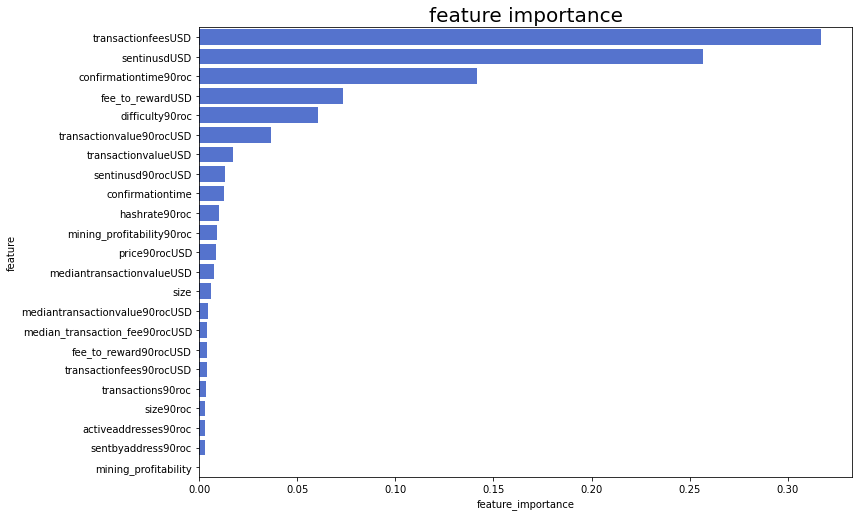

In [38]:
cmns.plot_feature_importance(imp_feat,'feature importance')

In [39]:
imp_feat[imp_feat['feature_importance']>0]


,feature,feature_importance
0,transactionfeesUSD,0.316849
1,sentinusdUSD,0.256835
2,confirmationtime90roc,0.141659
3,fee_to_rewardUSD,0.073225
4,difficulty90roc,0.060697
5,transactionvalue90rocUSD,0.036852
6,transactionvalueUSD,0.017484
7,sentinusd90rocUSD,0.013274
8,confirmationtime,0.012516
9,hashrate90roc,0.010245


In [40]:
selected=imp_feat[imp_feat['feature_importance']>0.001]

In [41]:
selected

,feature,feature_importance
0,transactionfeesUSD,0.316849
1,sentinusdUSD,0.256835
2,confirmationtime90roc,0.141659
3,fee_to_rewardUSD,0.073225
4,difficulty90roc,0.060697
5,transactionvalue90rocUSD,0.036852
6,transactionvalueUSD,0.017484
7,sentinusd90rocUSD,0.013274
8,confirmationtime,0.012516
9,hashrate90roc,0.010245


In [42]:
selected.feature_importance.sum()

0.9999903107804448

In [43]:
X_high=X[selected.feature]

In [44]:
X_high.shape

(1461, 22)

In [45]:
X_high.sort_index(axis=1,inplace=True)

/tmp/ipykernel_103894/1654798977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_high.sort_index(axis=1,inplace=True)


In [46]:
X_high['priceUSD']=np.ravel(y)

/tmp/ipykernel_103894/957662999.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<AxesSubplot:>

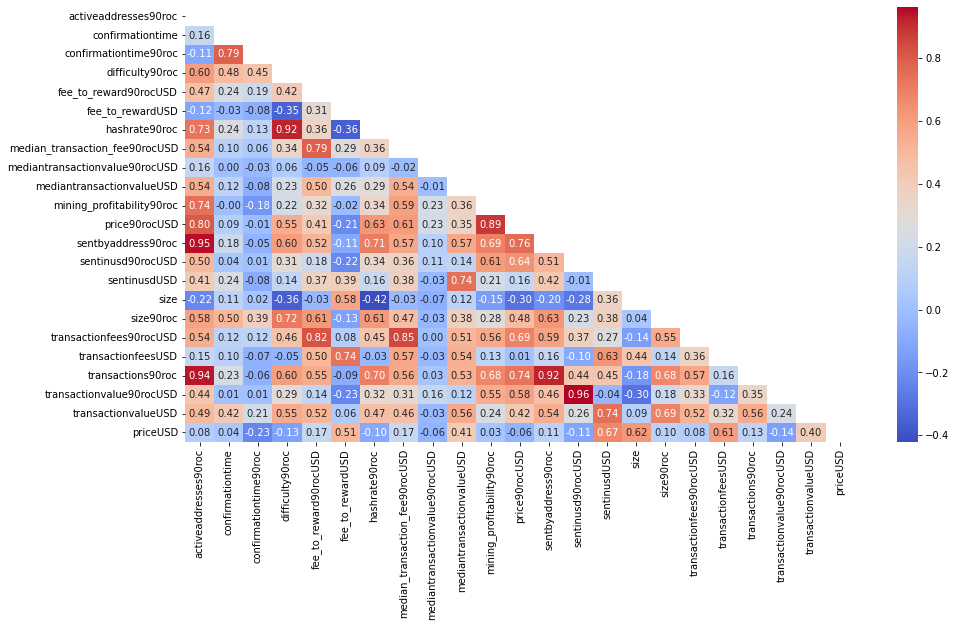

In [47]:
corr = X_high.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

In [48]:
X_high=X_high[X_high['priceUSD']!=1]

In [49]:
from sklearn.ensemble import IsolationForest
outlier=IsolationForest(contamination=0.3)
price=X_high['priceUSD']
price=price.values
price=np.reshape(price,(-1,1))
outlier.fit(price)
outs=outlier.predict(price)
X_high['outlier']=pd.DataFrame(zip(outs))
X_high=X_high.query('outlier != -1')
X_high.reset_index(drop=True,inplace=True)
X_high.drop(columns=['outlier'],inplace=True)

In [50]:
X_high.to_csv('train_eth_selected_features.csv',sep=',',index=False)

In [51]:
X_high.columns

Index(['activeaddresses90roc', 'confirmationtime', 'confirmationtime90roc',
       'difficulty90roc', 'fee_to_reward90rocUSD', 'fee_to_rewardUSD',
       'hashrate90roc', 'median_transaction_fee90rocUSD',
       'mediantransactionvalue90rocUSD', 'mediantransactionvalueUSD',
       'mining_profitability90roc', 'price90rocUSD', 'sentbyaddress90roc',
       'sentinusd90rocUSD', 'sentinusdUSD', 'size', 'size90roc',
       'transactionfees90rocUSD', 'transactionfeesUSD', 'transactions90roc',
       'transactionvalue90rocUSD', 'transactionvalueUSD', 'priceUSD'],
      dtype='object')